<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/tutorials/P2.1_CNN_classification_with_torch.nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


# Tutorial Contents
----------------

In this tutorial, you will learn:

- How to build your own CNN network for classification.

- What is a pre-trained model. How to load it and use it for classification.

- How to fine-tune the pre-trained model by transfer Learning and use it in another dataset.

# Prepare
We already had some of our own help functions in the tutorials P1.1. In this tutorial, we will reuse some of them for convenience.


We use code from previous tutorial to build Mnist dataset.

In [2]:
import torch
from torchvision.datasets import MNIST

mnist_train = MNIST("2AMM10/", train=True, download=True)
mnist_test = MNIST("2AMM10/", train=False, download=True)

x_train = mnist_train.data.type(torch.FloatTensor).reshape((-1,784))/255
y_train = mnist_train.targets
x_valid = mnist_test.data.type(torch.FloatTensor).reshape((-1,784))/255
y_valid = mnist_test.targets

9913344it [03:53, 42536.32it/s]
Extracting 2AMM10/MNIST/raw/train-images-idx3-ubyte.gz to 2AMM10/MNIST/raw

29696it [00:00, 378305.48it/s]           
Extracting 2AMM10/MNIST/raw/train-labels-idx1-ubyte.gz to 2AMM10/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

1649664it [00:00, 2235725.41it/s]                           
Extracting 2AMM10/MNIST/raw/t10k-images-idx3-ubyte.gz to 2AMM10/MNIST/raw

5120it [00:00, 3911627.77it/s]          Extracting 2AMM10/MNIST/raw/t10k-labels-idx1-ubyte.gz to 2AMM10/MNIST/raw

Processing...
Done!

/home/nimo/.anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppre

And reuse some functions to create dataloader and train the model

In [3]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)
    
    return loss.item(), corrects, len(xb)

In [4]:
from tqdm import tqdm
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):
        
        
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

   

In [5]:
from torch.utils.data import DataLoader
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [6]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

bs=64
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)



# 1. Build your own CNN network


We are now going to build our neural network with three convolutional layers.We will use Pytorch's predefined
[Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)



In [7]:
from torch import nn

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.fc =    nn.Linear(10, 10)


    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        xb=xb.view(xb.size(0), -1)
        xb = self.fc(xb)
        return xb



[Momentum](https://cs231n.github.io/neural-networks-3/#sgd)is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [8]:
from torch import optim
import torch.nn.functional as F


epochs=2
lr = 0.1

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy


fit(epochs, model, loss_func, opt, train_dl, valid_dl)

100%|██████████| 2/2 [00:05<00:00,  2.80s/it]EPOCH: 2/2 LOSS: 0.2519 ACC: 0.9241  VAL-LOSS: 0.2166 VAL-ACC: 0.9361 



## nn.Sequential


``torch.nn`` has another handy class we can use to simplify our code:
[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential).
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [9]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with ``Sequential`` is simply:



In [10]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(10, 10),
)

In [11]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=2
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

100%|██████████| 2/2 [00:05<00:00,  2.89s/it]EPOCH: 2/2 LOSS: 0.2461 ACC: 0.9258  VAL-LOSS: 0.1934 VAL-ACC: 0.9446 



## Wrapping DataLoader


Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer by
moving the data preprocessing into a generator:



In [13]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.



In [14]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(10, 10),
)


Let's try it out:



In [15]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=2
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

100%|██████████| 2/2 [00:06<00:00,  3.10s/it]EPOCH: 2/2 LOSS: 0.2665 ACC: 0.9201  VAL-LOSS: 0.2269 VAL-ACC: 0.9320 



Using your GPU
---------------

First check that your GPU is working in Pytorch:



In [16]:
print(torch.cuda.is_available())

True


And then create a device object for it:



In [17]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [18]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finally, we can move our model to the GPU.



You should find it runs faster now:



In [19]:
model.to(dev)

lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=2
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

100%|██████████| 2/2 [00:03<00:00,  1.51s/it]EPOCH: 2/2 LOSS: 0.1746 ACC: 0.9465  VAL-LOSS: 0.1895 VAL-ACC: 0.9443 



# 2. Pre-trained model
---------------

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. [ImageNet](http://www.image-net.org/), which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


## Download pre-trained model

We can load the pre-defined model `resnet18` from `torchvision.models` and load the pre-trained parameters by setting
`pretrained=True`. The ResNet model compromises of a bunch of ResNet blocks (Combination of convolution and identity block) and a fully connected layer. The model is trained on Imagenet dataset.

In [20]:
from torchvision import models

In [21]:
model_ft = models.resnet18(pretrained=True)


Now let's print the model structure

In [22]:
print (model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Download example images

Since this model is already trained in imagenet, we can use it for classification directly. Let's test at few example images. We need to download the demonstrative images and labels at this [link](https://drive.google.com/drive/folders/1y8EpmXGYuZktfb0QLxF8Pg-w5HGvbtbX?usp=sharing), and upload them into your own google drive so you can see them in your colab.

after you upload these data to your own google drive, mount them to drive folder so we can use them in colab by:

In [ ]:
from google.colab import drive
!mkdir drive
drive.mount('drive')

Then we list all the data in your drive to see if mount successfully.

In [ ]:
!ls "drive/My Drive/"

We load the label Json file and create a label name list `idx2label`, **note that please modify the path according to your only file location**

In [23]:
# load image class labels
import json
idx2label = []

# modify the path according to your own file location
with open("./CNN_tutorial_data/imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    

[`transfroms`](https://pytorch.org/vision/stable/transforms.html?highlight=torchvision%20transforms) are common image transformations provided by torchvision. They can be chained together using `Compose`. 
Here we define the `Imagenet_transform` to preprocess the images in the same way as when they are used to train the pre-trained model.

In [24]:
from torchvision import transforms
# image preprocess
Imagenet_transform = transforms.Compose([            
transforms.Resize(256),                    
transforms.CenterCrop(224),                
transforms.ToTensor(),                     
transforms.Normalize(                     
mean=[0.485, 0.456, 0.406],                
std=[0.229, 0.224, 0.225]                  
)
])

## Make classification by pre-trained model

Then we load the example images, and make predictions directly by our pre-trained model `resnet-18`

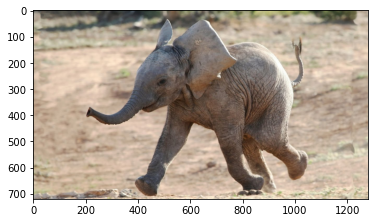

Indian_elephant, with probability: 48.93678665161133
tusker, with probability: 26.32560157775879
African_elephant, with probability: 17.841524124145508
triceratops, with probability: 3.883211374282837
Mexican_hairless, with probability: 1.8997629880905151


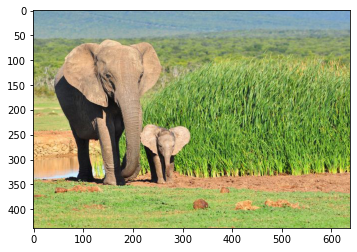

African_elephant, with probability: 91.1495590209961
tusker, with probability: 5.625303268432617
Indian_elephant, with probability: 3.223378896713257
Arabian_camel, with probability: 0.0004718512063845992
zebra, with probability: 0.0003504484484437853


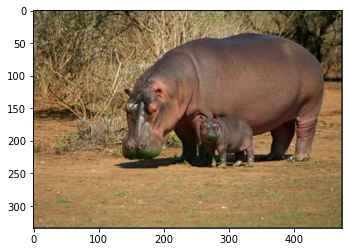

hippopotamus, with probability: 99.98336791992188
hog, with probability: 0.007531443610787392
Mexican_hairless, with probability: 0.003924155607819557
armadillo, with probability: 0.0020051037427037954
warthog, with probability: 0.0006895457045175135


In [25]:
from PIL import Image
import os

def load_img_preprocess(img_path):
    
    img = Image.open(img_path)

    x = Imagenet_transform(img)
    x = torch.unsqueeze(x, 0)
    return {"img": img, "x": x}

# modify the path according to your own file location
image_fold_path= "./CNN_tutorial_data/images"

elephant1 = load_img_preprocess(os.path.join(image_fold_path,'elephant1.jpg'))
elephant2 = load_img_preprocess(os.path.join(image_fold_path,'elephant2.jpg'))
hippo1 = load_img_preprocess(os.path.join(image_fold_path,'hippo1.jpg'))

import matplotlib.pyplot as plt
def show_image_predictions(img_obj):
    plt.imshow(img_obj["img"])
    plt.show()
    
    model_ft.eval()
    out = model_ft(img_obj["x"])
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    _, indices = torch.sort(out, descending=True)
    for idx in indices[0][:5]:
        print ("{}, with probability: {}".format( idx2label[idx] ,  percentage[idx].item()))
        
show_image_predictions(elephant1)
show_image_predictions(elephant2)
show_image_predictions(hippo1)

# 3. Transfer Learning 

The basic premise of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. We usually freeze the early convolutional layers of the network and only train the last few layers which make a prediction. The idea is the convolutional layers extract general, low-level features that are applicable across images — such as edges, patterns, gradients — and the later layers identify specific features within an image such as eyes or wheels.


Thus, we  use the pre-train `Resnet-18` in section 2 and apply it to our own new task because there are universal, low-level features shared between images. Here we use MNIST as our new task

![avatar](https://miro.medium.com/max/638/1*ZkPBqU8vx2vAgcLpz9pi5g.jpeg)

This Resnet-18 model has over 33 million parameters, but we’ll train only the very last few fully-connected layers. Initially, we freeze all of the model’s weights:

In [26]:
for param in model_ft.parameters():   
    param.requires_grad = False

Resnet-18 is pre-trained in image net with 1000 categories, whereas MNIST has only 10. We need to modify the size of the last layer accordingly. 
Parameters of newly constructed modules have requires_grad=True by default.

In [27]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10..
model_ft.fc = nn.Linear(num_ftrs, 10)

Move model to GPU if appliable.

In [28]:
model_ft = model_ft.to(dev)

Print the parameters with `requires_grad=True`, so that double-check that only the last layer could be trained. 

In [29]:
for name, param in model_ft.named_parameters():
    if param.requires_grad:
          print(name)

fc.weight
fc.bias


The input image shape of resnet18 is `(3, 224, 224)`, whereas the image shape of MNIST dataset is `(1, 28, 28)`. We need `transforms` to preprocess our input data accordingly. 

In [30]:
Mnist_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
    ])

mnist_train = MNIST("2AMM10/", train=True, download=True, transform=Mnist_transform)
mnist_test = MNIST("2AMM10/", train=False, download=True, transform=Mnist_transform)


We define a little help function here to help us transfer data to GPU

In [31]:
def preprocess_gpu(x, y):
    return x.to(dev), y.to(dev)

train_dl, valid_dl = get_data(mnist_train, mnist_test, bs)
train_dl = WrappedDataLoader(train_dl, preprocess_gpu)
valid_dl = WrappedDataLoader(valid_dl, preprocess_gpu)

Train the model with `fit` funtion

In [32]:
lr = 0.1
opt = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
epochs=2
loss_func = F.cross_entropy

fit(epochs, model_ft, loss_func, opt, train_dl, valid_dl)

100%|██████████| 2/2 [03:56<00:00, 118.07s/it]EPOCH: 2/2 LOSS: 0.3624 ACC: 0.9423  VAL-LOSS: 0.2807 VAL-ACC: 0.9583 

